## Inflation Rate Scaling

In [12]:
import sys
sys.path.insert(1, '../../../../utils')
import numpy as np
from numpy import log, ndarray, array, mean, sqrt, arange
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range, to_datetime, concat
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend, setp
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
import dslabs_functions
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components, plot_multiline_chart, \
series_train_test_split, plot_forecasting_series, plot_multibar_chart, FORECAST_MEASURES, plot_forecasting_eval, plot_forecasting_series, \
PersistenceOptimistRegressor, PersistenceRealistRegressor, scale_all_dataframe
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from statsmodels.tsa.stattools import adfuller
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


(Date
 2011-01-01    4.297083
 2012-01-01    4.597333
 2013-01-01    8.034000
 2014-01-01    6.715000
 2015-01-01    3.986667
 Name: Inflation Rate (%), dtype: float64,
 Date
 2020-01-01    6.350
 2021-01-01    0.530
 2022-01-01    5.480
 2023-01-01    5.145
 Name: Inflation Rate (%), dtype: float64)

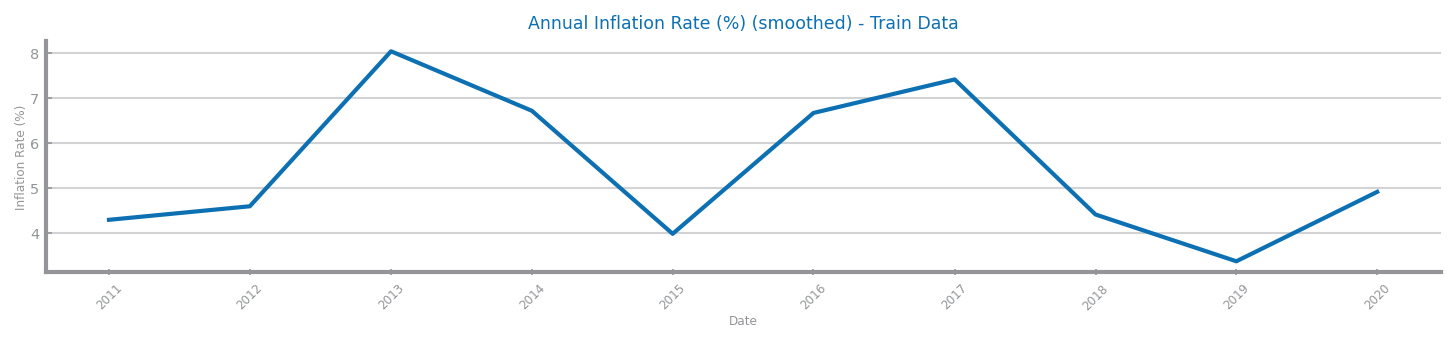

In [15]:
target = "Inflation Rate (%)"
chart_target = "inflation"
file_tag = "Scaling"

train_path = "../../data/prepared/smoothing/inflation_train_smoothing.csv"
test_path  = "../../data/prepared/smoothing/inflation_test_smoothing.csv"
train_multi_path = "../../data/prepared/smoothing/inflation_train_multi_smoothing.csv"
test_multi_path  = "../../data/prepared/smoothing/inflation_test_multi_smoothing.csv"

train_df = read_csv(train_path, parse_dates=["Date"], index_col="Date")
train: Series = train_df[target]
train.index = to_datetime(train.index)  # ensure proper datetime index

# Load test
test_df = read_csv(test_path, parse_dates=["Date"], index_col="Date")
test: Series = test_df[target]
test.index = to_datetime(test.index)

train_multi: DataFrame = read_csv(train_multi_path, parse_dates=["Date"], index_col="Date")
train_multi.index = to_datetime(train_multi.index)

test_multi: DataFrame = read_csv(test_multi_path, parse_dates=["Date"], index_col="Date")
test_multi.index = to_datetime(test_multi.index)

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train.index.to_list(),
    train.to_list(),
    xlabel=train.index.name,
    ylabel=target,
    title=f"Annual {target} (smoothed) - Train Data",
)

train.head(), test.head()

StandardScaler: train shape=(10,), test shape=(4,)
MinMaxScaler: train shape=(10,), test shape=(4,)
RobustScaler: train shape=(10,), test shape=(4,)


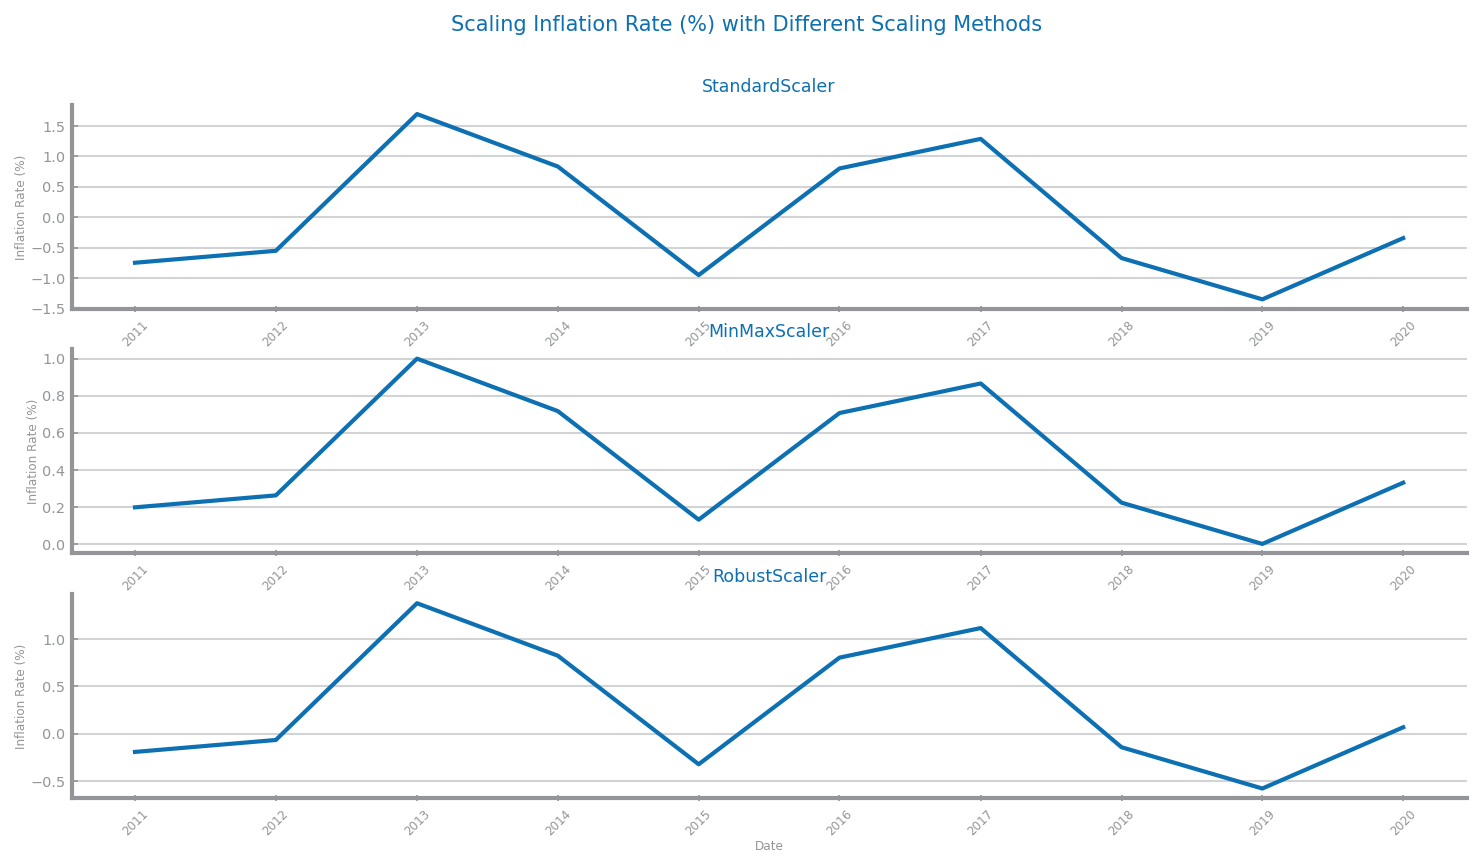

In [3]:
# Define scaling methods to evaluate
scaling_methods = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
}

# Apply each scaling method and store results
scaled_data = {}
fig, axs = subplots(len(scaling_methods), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(scaling_methods)))
fig.suptitle(f"{file_tag} {target} with Different Scaling Methods")

# Combine train and test for proper scaling (fit on train, transform both)
combined = concat([train, test])

for idx, (method_name, scaler) in enumerate(scaling_methods.items()):
    if method_name == "None":
        # No scaling
        scaled_train = train
        scaled_test = test
    else:
        # Fit scaler on training data only, then transform both
        scaler.fit(train.values.reshape(-1, 1))
        scaled_train_values = scaler.transform(train.values.reshape(-1, 1)).flatten()
        scaled_test_values = scaler.transform(test.values.reshape(-1, 1)).flatten()
        
        scaled_train = Series(scaled_train_values, index=train.index, name=target)
        scaled_test = Series(scaled_test_values, index=test.index, name=target)
    
    # Store scaled data
    scaled_data[f"{method_name}_train"] = scaled_train
    scaled_data[f"{method_name}_test"] = scaled_test
    
    # Plot
    ax = axs[idx] if len(scaling_methods) > 1 else axs
    plot_line_chart(
        scaled_train.index.to_list(),
        scaled_train.to_list(),
        ax=ax,
        xlabel=scaled_train.index.name,
        ylabel=target,
        title=f"{method_name}",
    )
    
    print(f"{method_name}: train shape={scaled_train.shape}, test shape={scaled_test.shape}")

show()

In [19]:
scaler_multi = MinMaxScaler()

scaler_multi.fit(train_multi.values)

train_multi_minmax = DataFrame(
    scaler_multi.transform(train_multi.values),
    index=train_multi.index,
    columns=train_multi.columns,
)

test_multi_minmax = DataFrame(
    scaler_multi.transform(test_multi.values),
    index=test_multi.index,
    columns=test_multi.columns,
)


**Evalutation**

**Persistent Realist**

<Axes: xlabel='date', ylabel='Inflation Rate (%)'>

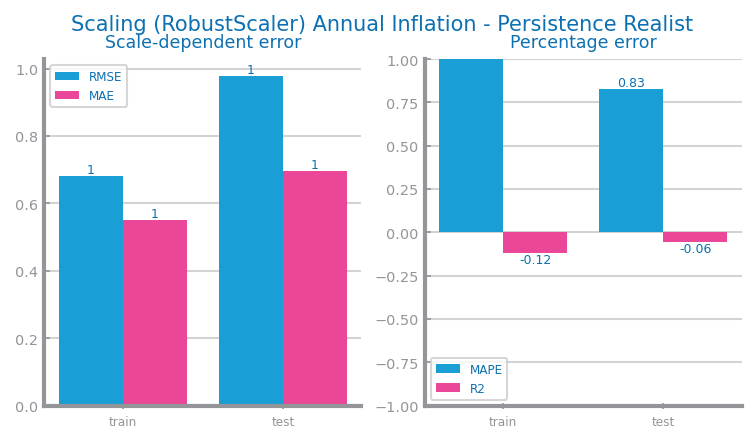

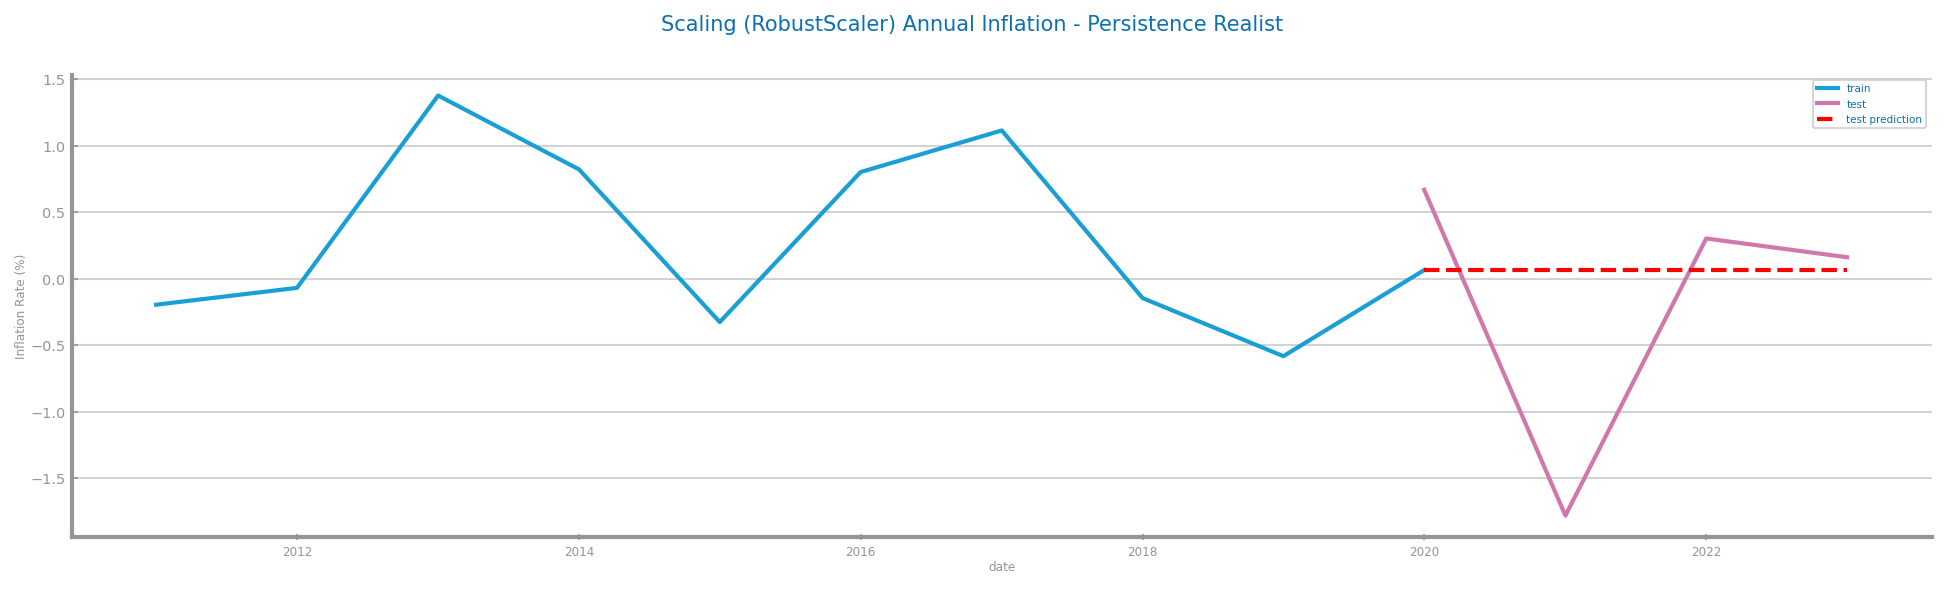

In [4]:

timecol="date"
method_name = "RobustScaler"
train_robust = scaled_data[f"{method_name}_train"]
test_robust = scaled_data[f"{method_name}_test"]

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_robust)
prd_trn: Series = fr_mod.predict(train_robust)
prd_tst: Series = fr_mod.predict(test_robust)

plot_forecasting_eval(train_robust, test_robust, prd_trn, prd_tst, title=f"Scaling ({method_name}) Annual Inflation - Persistence Realist")
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_persistence_real_{method_name}_eval.png")

plot_forecasting_series(
    train_robust,
    test_robust,
    prd_tst,
    title=f"Scaling ({method_name}) Annual Inflation - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_persistence_real_{method_name}_forecast.png")


<Axes: xlabel='date', ylabel='Inflation Rate (%)'>

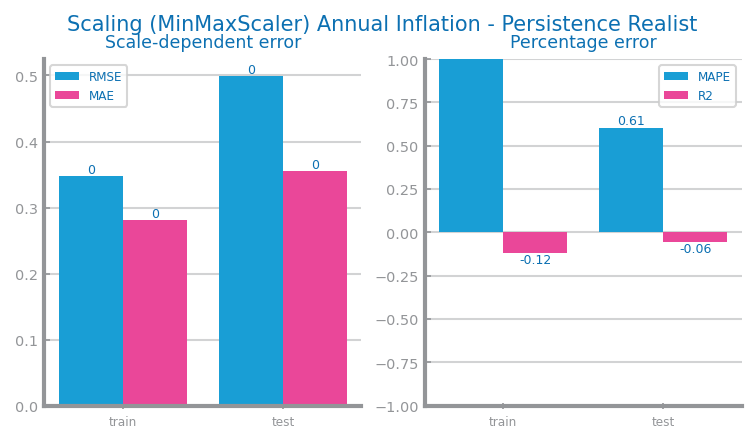

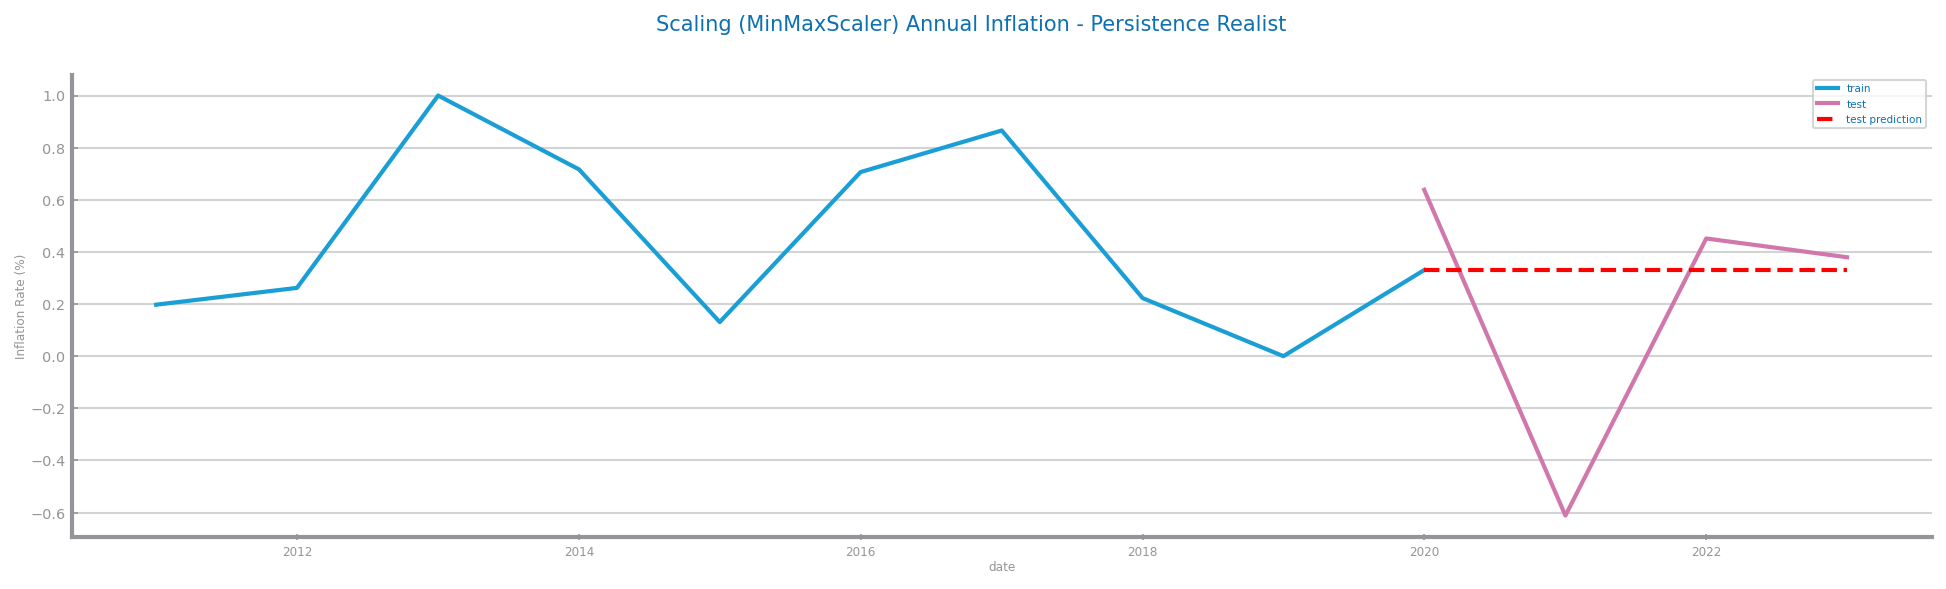

In [5]:

timecol="date"
method_name = "MinMaxScaler"
train_minmax = scaled_data[f"{method_name}_train"]
test_minmax = scaled_data[f"{method_name}_test"]

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_minmax)
prd_trn: Series = fr_mod.predict(train_minmax)
prd_tst: Series = fr_mod.predict(test_minmax)

plot_forecasting_eval(train_minmax, test_minmax, prd_trn, prd_tst, title=f"Scaling ({method_name}) Annual Inflation - Persistence Realist")
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_persistence_real_{method_name}_eval.png")

plot_forecasting_series(
    train_minmax,
    test_minmax,
    prd_tst,
    title=f"Scaling ({method_name}) Annual Inflation - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_persistence_real_{method_name}_forecast.png")


<Axes: xlabel='date', ylabel='Inflation Rate (%)'>

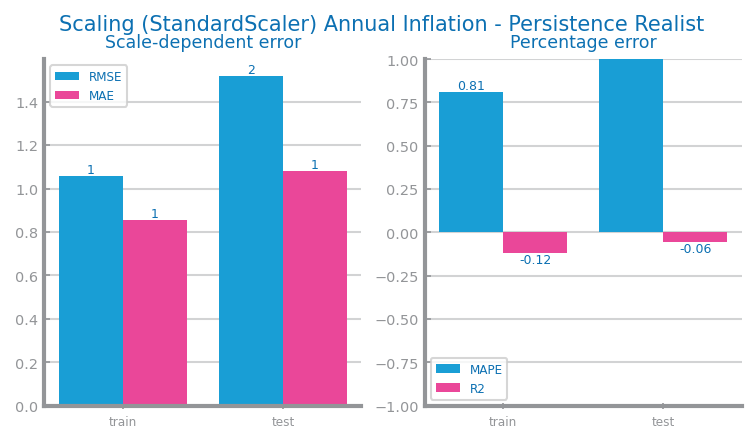

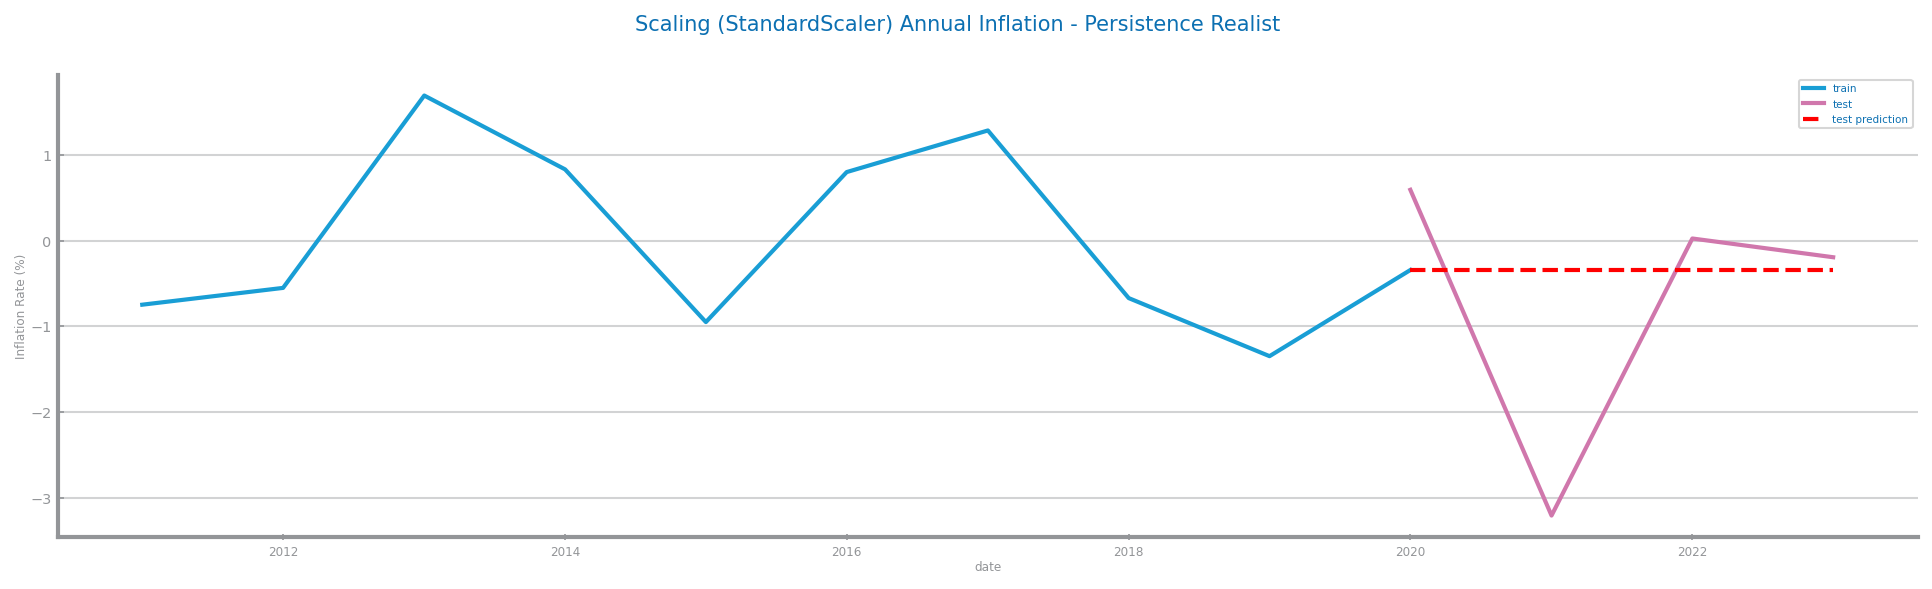

In [6]:

timecol="date"
method_name = "StandardScaler"
train_standard = scaled_data[f"{method_name}_train"]
test_standard = scaled_data[f"{method_name}_test"]

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_standard)
prd_trn: Series = fr_mod.predict(train_standard)
prd_tst: Series = fr_mod.predict(test_standard)

plot_forecasting_eval(train_standard, test_standard, prd_trn, prd_tst, title=f"Scaling ({method_name}) Annual Inflation - Persistence Realist")
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_persistence_real_{method_name}_eval.png")

plot_forecasting_series(
    train_standard,
    test_standard,
    prd_tst,
    title=f"Scaling ({method_name}) Annual Inflation - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_persistence_real_{method_name}_forecast.png")


**Linear regression**

<Axes: xlabel='date', ylabel='Inflation Rate (%)'>

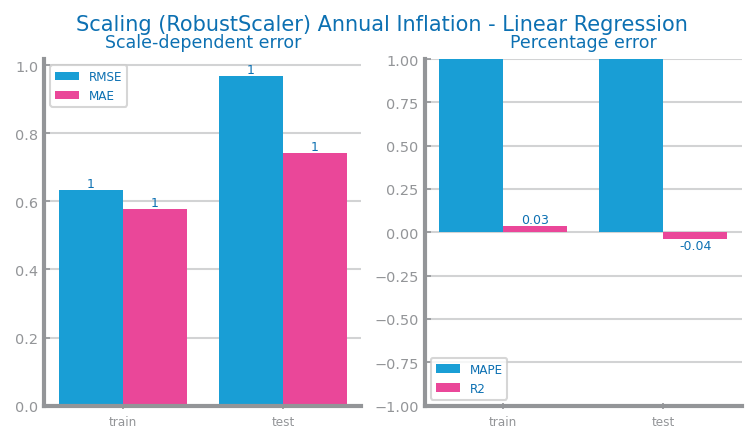

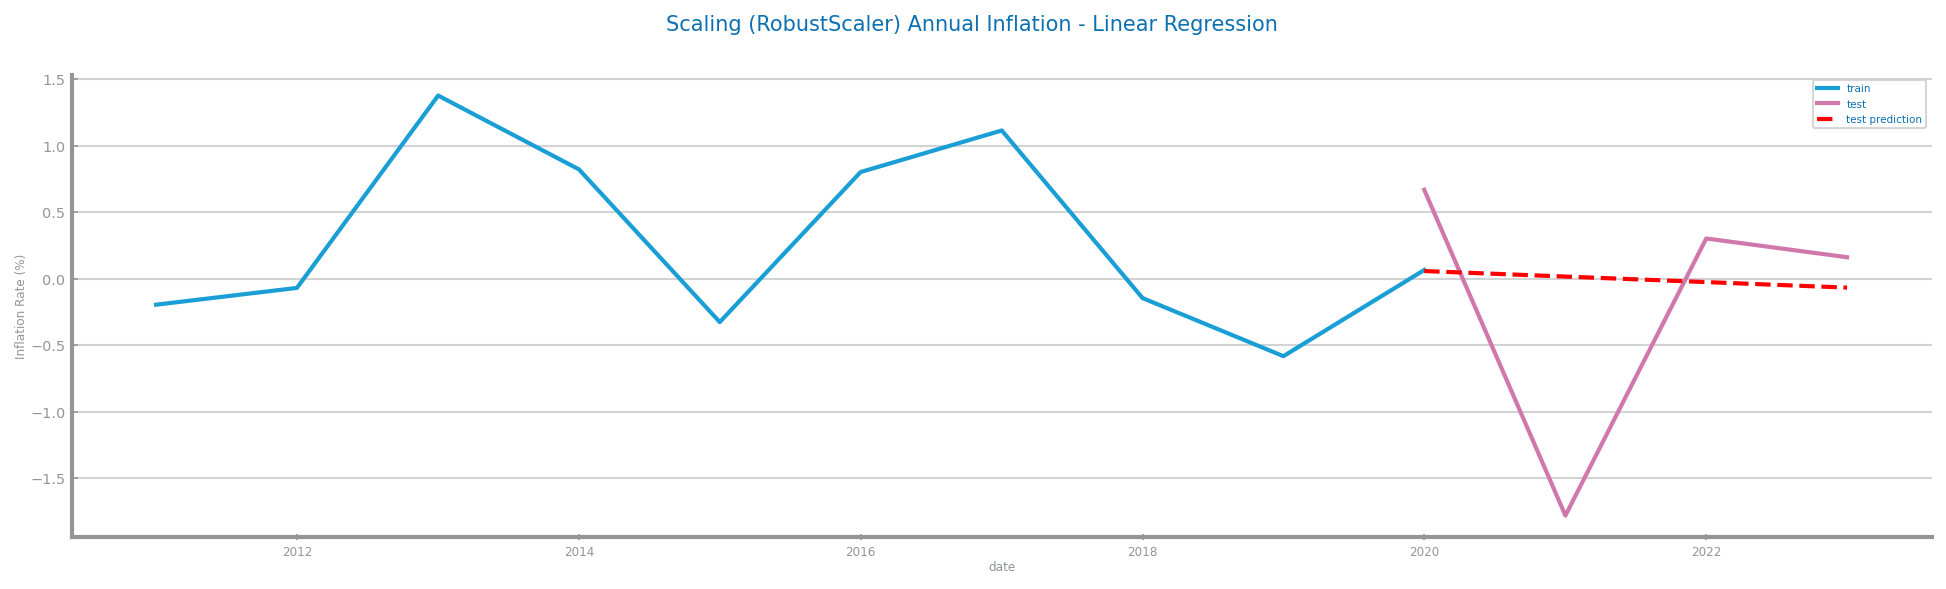

In [7]:

method_name = "RobustScaler"
train_data = scaled_data[f"{method_name}_train"]
test_data = scaled_data[f"{method_name}_test"]

n_trn = len(train_data)
n_tst = len(test_data)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = train_data.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = test_data.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train_data.index)
prd_tst: Series = Series(model.predict(tstX), index=test_data.index)

plot_forecasting_eval(
    train_data,
    test_data,
    prd_trn,
    prd_tst,
    title=f"Scaling ({method_name}) Annual Inflation - Linear Regression"
)
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_linear_regression_{method_name}_eval.png")

plot_forecasting_series(
    train_data,
    test_data,
    prd_tst,
    title=f"Scaling ({method_name}) Annual Inflation - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_linear_regression_{method_name}_forecast.png")


<Axes: xlabel='date', ylabel='Inflation Rate (%)'>

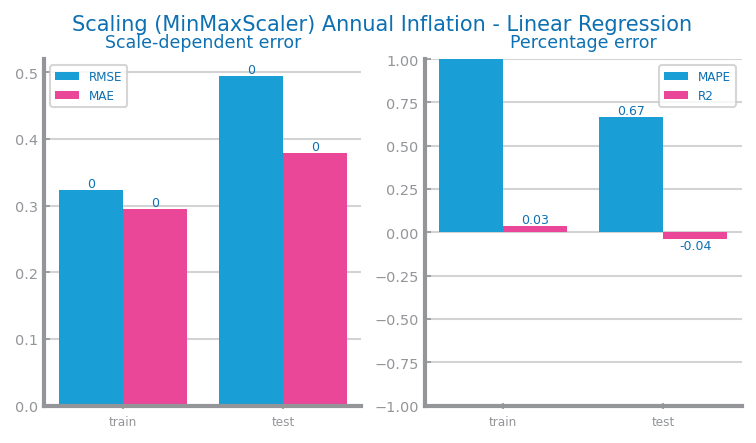

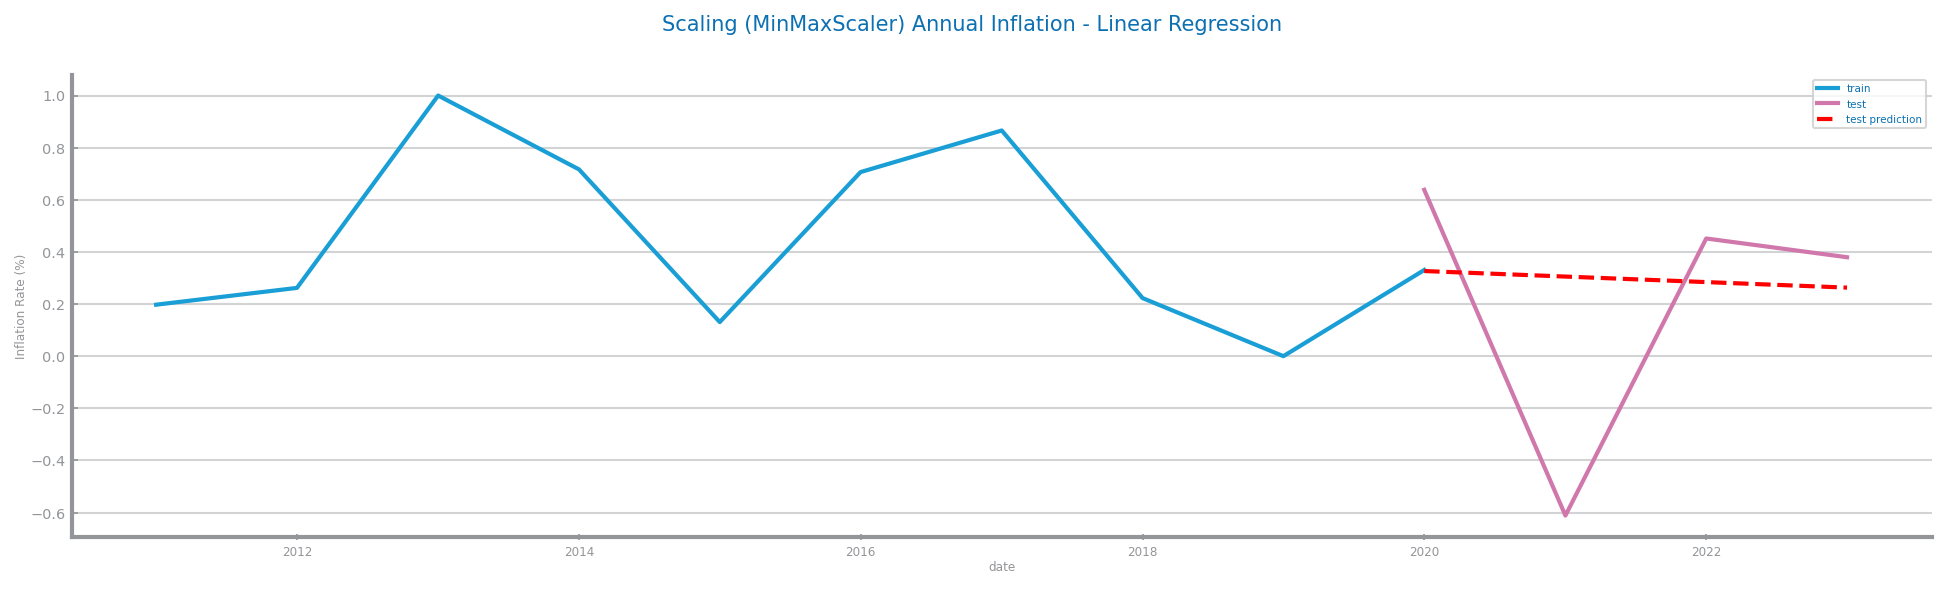

In [8]:

method_name = "MinMaxScaler"
train_data = scaled_data[f"{method_name}_train"]
test_data = scaled_data[f"{method_name}_test"]

n_trn = len(train_data)
n_tst = len(test_data)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = train_data.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = test_data.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train_data.index)
prd_tst: Series = Series(model.predict(tstX), index=test_data.index)

plot_forecasting_eval(
    train_data,
    test_data,
    prd_trn,
    prd_tst,
    title=f"Scaling ({method_name}) Annual Inflation - Linear Regression"
)
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_linear_regression_{method_name}_eval.png")

plot_forecasting_series(
    train_data,
    test_data,
    prd_tst,
    title=f"Scaling ({method_name}) Annual Inflation - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_linear_regression_{method_name}_forecast.png")


<Axes: xlabel='date', ylabel='Inflation Rate (%)'>

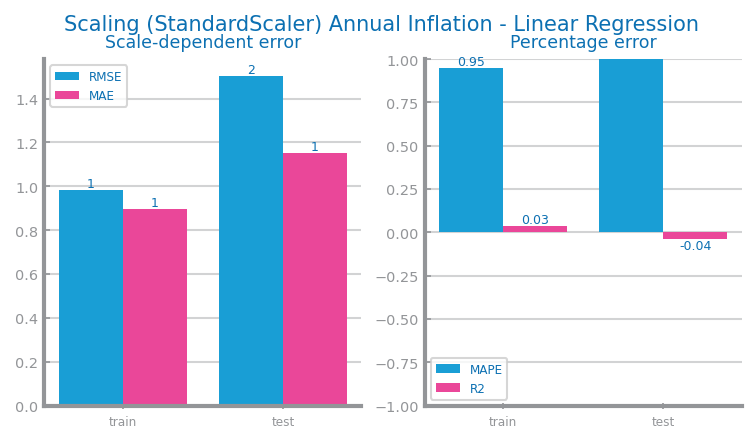

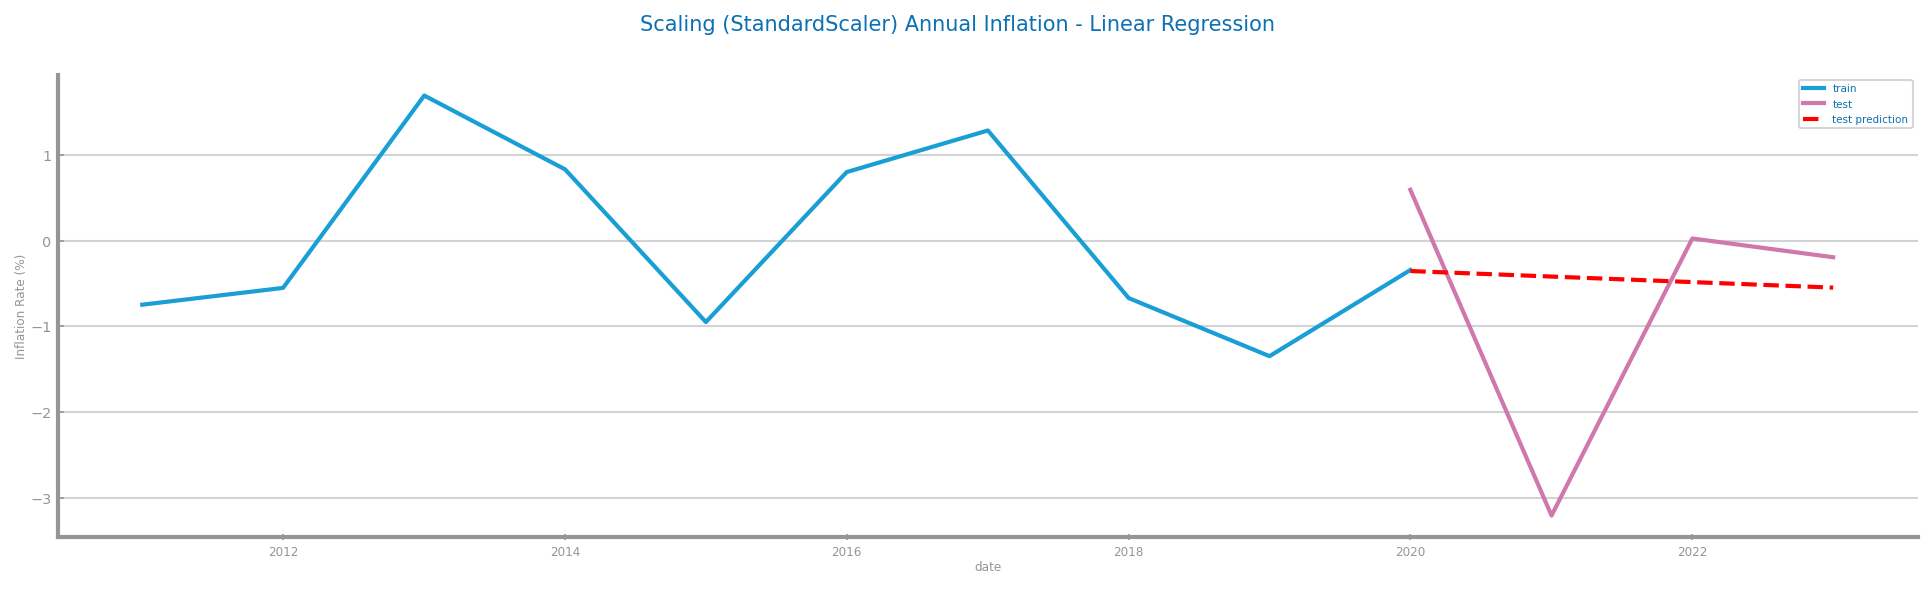

In [9]:

method_name = "StandardScaler"
train_data = scaled_data[f"{method_name}_train"]
test_data = scaled_data[f"{method_name}_test"]

n_trn = len(train_data)
n_tst = len(test_data)

trnX = np.arange(n_trn).reshape(-1, 1)
trnY = train_data.to_numpy()

tstX = np.arange(n_trn, n_trn + n_tst).reshape(-1, 1)
tstY = test_data.to_numpy()

# Train model
model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train_data.index)
prd_tst: Series = Series(model.predict(tstX), index=test_data.index)

plot_forecasting_eval(
    train_data,
    test_data,
    prd_trn,
    prd_tst,
    title=f"Scaling ({method_name}) Annual Inflation - Linear Regression"
)
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_linear_regression_{method_name}_eval.png")

plot_forecasting_series(
    train_data,
    test_data,
    prd_tst,
    title=f"Scaling ({method_name}) Annual Inflation - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
#savefig(f"../../charts/lab5/preparation/scaling/{file_tag}_linear_regression_{method_name}_forecast.png")


**Evaluation notes**<br>
The best results are achieved with MinMaxScaler combined with the Persistence Realist model, due to its lowest Test MAE (0.35) and significantly better Test MAPE (0.61).

In [20]:
output_train_path = "../../data/prepared/scaling/inflation_train_scaling.csv"
output_train_multi_path = "../../data/prepared/scaling/inflation_train_multi_scaling.csv"
output_test_path  = "../../data/prepared/scaling/inflation_test_scaling.csv"
output_test_multi_path  = "../../data/prepared/scaling/inflation_test_multi_scaling.csv"

# Ensure they are DataFrames so the index is preserved cleanly
train_minmax.to_frame(name="Inflation Rate (%)").to_csv(output_train_path)
test_minmax.to_frame(name="Inflation Rate (%)").to_csv(output_test_path)

train_multi_minmax.to_csv(output_train_multi_path)
test_multi_minmax.to_csv(output_test_multi_path)

print("Saved train/test sets.")

Saved train/test sets.
